In [1]:
import os
import numpy as np

import torch

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_theme()

from source.constants import RESULTS_PATH, PLOTS_PATH
from source.utils.uncertainty_measures import calculate_uncertainties
from source.utils.metrics import auroc, aupr, fpr_at_tpr_x

os.makedirs(PLOTS_PATH, exist_ok=True)

/system/apps/userenv/kschweig/quam/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
seed = 42

methods = ["deep_ensemble", "laplace", "mc_dropout"]
dataset_names = ["cifar10", "cifar100", "svhn", "tin", "lsun"]
n_classes = [10, 100, 10, 200, 10]
models = ["resnet18", "densenet169", "regnet"]

id = 3                                          # select dataset 
method = methods[0]                             # select method 
metric = [auroc, aupr, fpr_at_tpr_x][0]         # select metric

p_drop = 0.2                                # dropout rate of MC dropout    

model = models[0]                               # select model
runs = 5                                        # number of runs

# select id dataset
id_dataset = dataset_names[id]    
# infer number of classes from dataset
n_class = n_classes[dataset_names.index(id_dataset)]

print(id_dataset, method, model, metric.__name__)

tin deep_ensemble resnet18 auroc


In [3]:
if method == "deep_ensemble":
    path = os.path.join(RESULTS_PATH, f"{id_dataset}_{model}_seed{seed}")
elif method == "laplace":
    path = os.path.join(RESULTS_PATH, f"{id_dataset}_{model}_seed{seed}_laplace")
elif method == "mc_dropout":
    path = os.path.join(RESULTS_PATH, f"{id_dataset}_{model}_dropout{p_drop}_seed{seed}")

probits = list()

for dataset_name in dataset_names:
    p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
    p = p.reshape(len(p), runs, -1, n_class)
    probits.append(p)
    print(probits[-1].shape)

torch.Size([10000, 5, 10, 200])
torch.Size([10000, 5, 10, 200])
torch.Size([26032, 5, 10, 200])
torch.Size([10000, 5, 10, 200])
torch.Size([10000, 5, 10, 200])


In [4]:
uncertainties = list()

for d, ds_probits in enumerate(probits):
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

In [5]:
unc_names = ["A1", "A2", "A3", "B1", "B2", "B3", "C1", "C2", "C3"]
components = ["TU", "AU", "EU"]
arrow = " $\\rightarrow$ "

print("Unc. ", end="")
for unc_name in unc_names:
    print(f"& {unc_name} ", end="")
print(" \\\\")

for d in [_d for _d in range(len(dataset_names)) if _d != id]:
    print(f"\\hline & \\multicolumn{'{9}{c}{'}{id_dataset.upper() + arrow + dataset_names[d].upper()}{'}'} \\\\ \\cline{'{2-10}'} ")

    for c, comp in enumerate(components):
        print(f"{comp} ", end="")
        for measure in unc_names:
            scores = torch.cat((uncertainties[id][measure][c], uncertainties[d][measure][c]))
            aurocs = list()
            for r in range(runs):
                ys = torch.ones(size=(len(probits[id]) + len(probits[d]),), dtype=torch.long)
                ys[:len(probits[id])] = 0
                aurocs.append(metric(scores[:, r], ys).item() * 100)
            mean_str = f"{np.mean(aurocs):.2f}"#.lstrip('0')
            std_str = f"{np.std(aurocs):.2f}"#.lstrip('0')
            print(f"& ${mean_str}_{'{'}\pm {std_str}{'}'}$ ", end="")
        print(" \\\\")

Unc. & A1 & A2 & A3 & B1 & B2 & B3 & C1 & C2 & C3  \\
\hline & \multicolumn{9}{c}{TIN $\rightarrow$ CIFAR10} \\ \cline{2-10} 
TU & $64.67_{\pm 0.55}$ & $66.15_{\pm 0.55}$ & $65.14_{\pm 0.52}$ & $66.68_{\pm 0.09}$ & $67.96_{\pm 0.12}$ & $66.96_{\pm 0.11}$ & $66.68_{\pm 0.09}$ & $67.96_{\pm 0.12}$ & $66.96_{\pm 0.11}$  \\
AU & $65.98_{\pm 0.65}$ & $65.98_{\pm 0.65}$ & $65.98_{\pm 0.65}$ & $67.96_{\pm 0.12}$ & $67.96_{\pm 0.12}$ & $67.96_{\pm 0.12}$ & $68.46_{\pm 0.12}$ & $68.46_{\pm 0.12}$ & $68.46_{\pm 0.12}$  \\
EU & $61.92_{\pm 0.48}$ & $63.27_{\pm 0.31}$ & $62.20_{\pm 0.36}$ & $61.35_{\pm 0.28}$ & $50.00_{\pm 0.00}$ & $61.51_{\pm 0.22}$ & $62.37_{\pm 0.25}$ & $63.70_{\pm 0.12}$ & $62.40_{\pm 0.18}$  \\
\hline & \multicolumn{9}{c}{TIN $\rightarrow$ CIFAR100} \\ \cline{2-10} 
TU & $65.80_{\pm 0.32}$ & $67.27_{\pm 0.23}$ & $66.39_{\pm 0.24}$ & $68.24_{\pm 0.13}$ & $69.46_{\pm 0.09}$ & $68.73_{\pm 0.10}$ & $68.24_{\pm 0.13}$ & $69.46_{\pm 0.09}$ & $68.73_{\pm 0.10}$  \\
AU & $66.95_{\pm 

In [6]:
probits = list()

for id_ds, n_class in zip(dataset_names[:4], n_classes):

    if method == "deep_ensemble":
        path = os.path.join(RESULTS_PATH, f"{id_ds}_{model}_seed{seed}")
    elif method == "laplace":
        path = os.path.join(RESULTS_PATH, f"{id_ds}_{model}_seed{seed}_laplace")
    elif method == "mc_dropout":
        path = os.path.join(RESULTS_PATH, f"{id_ds}_{model}_dropout{p_drop}_seed{seed}")

    for dataset_name in dataset_names:
        p = torch.load(os.path.join(path, f"{dataset_name}_probits.pt")).to(torch.float32)
        p = p.reshape(len(p), runs, -1, n_class)
        probits.append(p)
        print(probits[-1].shape)

uncertainties = list()

for d, ds_probits in enumerate(probits):
    uncertainties.append(calculate_uncertainties(ds_probits, ds_probits))

torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 100])
torch.Size([10000, 5, 10, 100])
torch.Size([26032, 5, 10, 100])
torch.Size([10000, 5, 10, 100])
torch.Size([10000, 5, 10, 100])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([26032, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 10])
torch.Size([10000, 5, 10, 200])
torch.Size([10000, 5, 10, 200])
torch.Size([26032, 5, 10, 200])
torch.Size([10000, 5, 10, 200])
torch.Size([10000, 5, 10, 200])


In [7]:
all_perfs = list()
all_names = list()

for i in range((len(dataset_names) - 1) * len(dataset_names)):
    ind = i // len(dataset_names) * len(dataset_names) + (i // len(dataset_names))
    ood = i
    if ood == ind:
        continue
    all_names.append((dataset_names[ind - len(dataset_names) * (ind // len(dataset_names))], 
                      dataset_names[ood - len(dataset_names) * (ind // len(dataset_names))]))
    print(ind, ood, all_names[-1])
    for c, comp in enumerate(components):
        for measure in unc_names:
            if comp == "EU" and measure == "B2":
                continue # B2 is not defined for epistemic uncertainty
            scores = torch.cat((uncertainties[ind][measure][c], uncertainties[ood][measure][c]))
            for r in range(runs):
                ys = torch.ones(size=(len(probits[ind]) + len(probits[ood]),), dtype=torch.long)
                ys[:len(probits[ind])] = 0
                all_perfs.append(metric(scores[:, r], ys).item() * 100)

all_perfs = torch.tensor(all_perfs).reshape(len(dataset_names) - 1, len(dataset_names) - 1, (len(components) * len(unc_names)) - 1, runs)
print(all_perfs.shape)

0 1 ('cifar10', 'cifar100')
0 2 ('cifar10', 'svhn')
0 3 ('cifar10', 'tin')
0 4 ('cifar10', 'lsun')
6 5 ('cifar100', 'cifar10')
6 7 ('cifar100', 'svhn')
6 8 ('cifar100', 'tin')
6 9 ('cifar100', 'lsun')
12 10 ('svhn', 'cifar10')
12 11 ('svhn', 'cifar100')
12 13 ('svhn', 'tin')
12 14 ('svhn', 'lsun')
18 15 ('tin', 'cifar10')
18 16 ('tin', 'cifar100')
18 17 ('tin', 'svhn')
18 19 ('tin', 'lsun')
torch.Size([4, 4, 26, 5])


In [8]:
def plot(data, title, name:str = None):

    tu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#DD8452", "#CC6333"]
    au_colors = ["#5D8CD8", "#DD8452", "#55A868"]
    eu_colors = ["#8FB4EF", "#5D8CD8", "#4C72B0", "#F2AD85", "#CC6333", "#85BF91", "#55A868", "#418050"]

    # tu_colors = au_colors = eu_colors = sns.color_palette("deep")


    tu_labels = ["A1", "A2", "A3", "B/C1", "B/C2", "B/C3"]
    au_labels = ["A", "B", "C"]
    eu_labels = ["A1", "A2", "A3", "B1", "B3", "C1", "C2", "C3"]

    # Create a figure
    # fig, axs = plt.figure(figsize=(12, 3.2)), list()
    fig, axs = plt.figure(figsize=(8, 3.2)), list()

    # Create a GridSpec with 1 row and 3 columns, and specify relative widths
    gs = gridspec.GridSpec(1, 3, width_ratios=[6.25, 3.25, 8.25])

    # Create subplots in the specified grid locations
    axs.append(fig.add_subplot(gs[0]))
    axs.append(fig.add_subplot(gs[1], sharey=axs[-1]))
    axs.append(fig.add_subplot(gs[2], sharey=axs[-1]))

    for i in range(len(tu_labels)):
        b = axs[0].bar(tu_labels[i], data[i].mean(), yerr=data[i].std(), color=tu_colors[i], label=tu_labels[i], linewidth=0)
        # if i >= 3:
        #     axs[0].bar(i + b[0].get_width() / 4, data[i].mean(), color=eu_colors[2 + i], linewidth=0, width=b[0].get_width() / 2)
    axs[0].set_xlabel("TU")

    for i in range(len(au_labels)):
        tl = 9
        axs[1].bar(au_labels[i], data[tl + i * 3].mean(), yerr=data[tl + i * 3].std(), color=au_colors[i], label=au_labels[i], linewidth=0)
    axs[1].set_xlabel("AU")

    for i in range(len(eu_labels)):
        tl = 18
        axs[2].bar(eu_labels[i], data[tl + i].mean(), yerr=data[tl + i].std(), color=eu_colors[i], label=eu_labels[i], linewidth=0)
    axs[2].set_xlabel("EU")

    # set ylim to minimum and maximum values
    for i in range(3):
        axs[i].hlines(data.mean(dim=-1).min() if metric == fpr_at_tpr_x else data.mean(dim=-1).max(), 
                      -0.625, len([tu_labels, au_labels, eu_labels][i]) - 0.375, colors="black", linestyles="dashed", alpha=0.3)
    
    data_range = (data.mean(dim=-1) + data.std(dim=-1)).max().item() - (data.mean(dim=-1) - data.std(dim=-1)).min().item()
    plt.ylim([(data.mean(dim=-1) - data.std(dim=-1)).min().item() - data_range * 0.05, 
              (data.mean(dim=-1) + data.std(dim=-1)).max().item() + data_range * 0.05])
    axs[0].set_ylabel({auroc: "AUROC", aupr: "AUPR", fpr_at_tpr_x: "FPR95"}[metric])
    axs[1].set_title(title, fontsize=14)

    # Optionally, hide y-axis labels for all but the first plot
    plt.setp(axs[1].get_yticklabels(), visible=False)
    plt.setp(axs[2].get_yticklabels(), visible=False)

    for ax, n_data in zip(axs, [len(tu_labels), len(au_labels), len(eu_labels)]):
        ax.set_xlim(-0.625, n_data - 0.375)

    plt.tight_layout()
    plt.show()
    if name is not None:
        fig.savefig(os.path.join(PLOTS_PATH, f"{name}.pdf"))


torch.Size([26, 5])


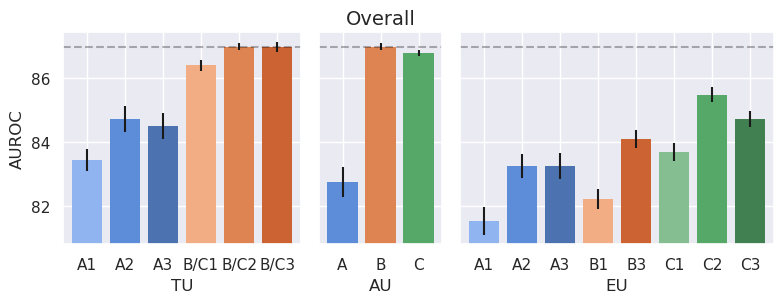

In [9]:
# [IND, OOD, R, U]
plt_data = torch.mean(all_perfs, dim=(0, 1))
# [R, U]

print(plt_data.shape)

plot(plt_data, "Overall", f"ood_{method}_{model}_{metric.__name__}_overall")

torch.Size([4, 4, 26, 5])


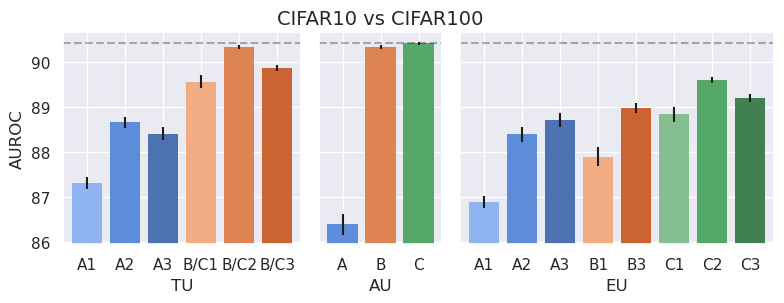

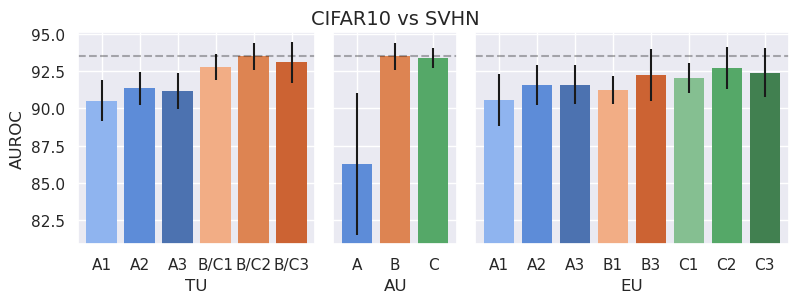

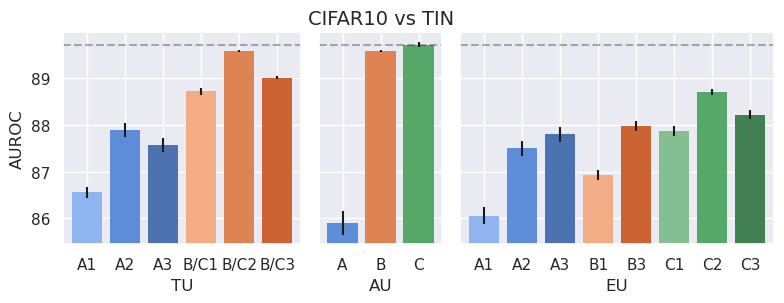

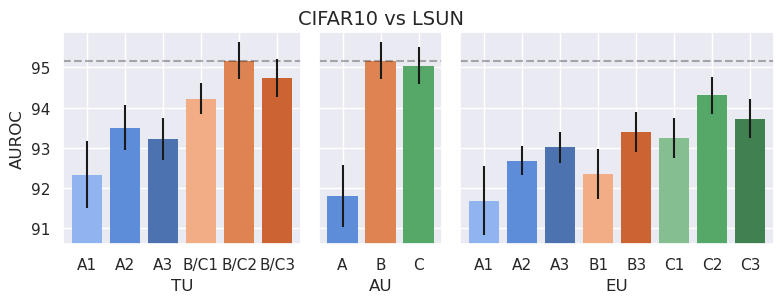

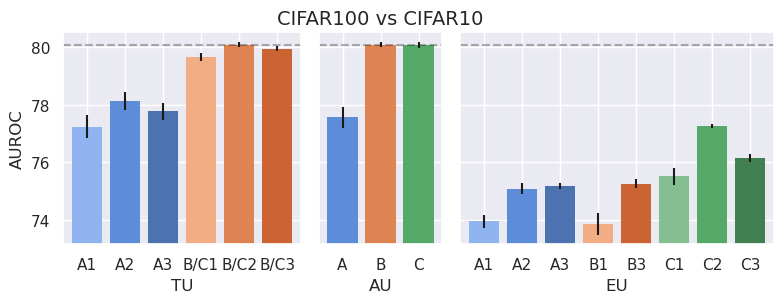

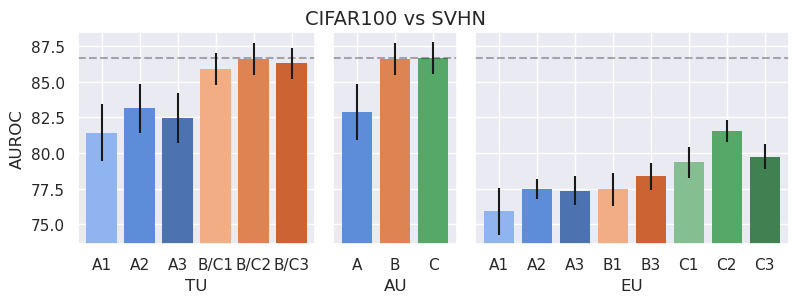

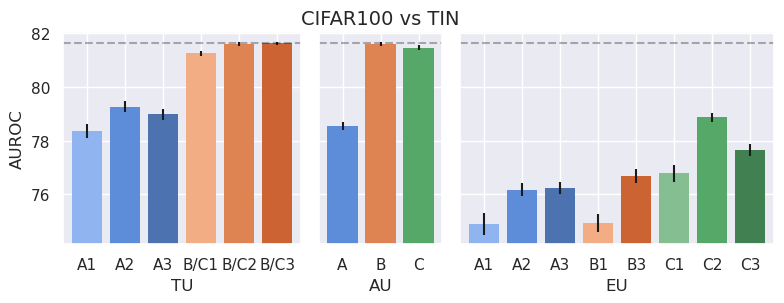

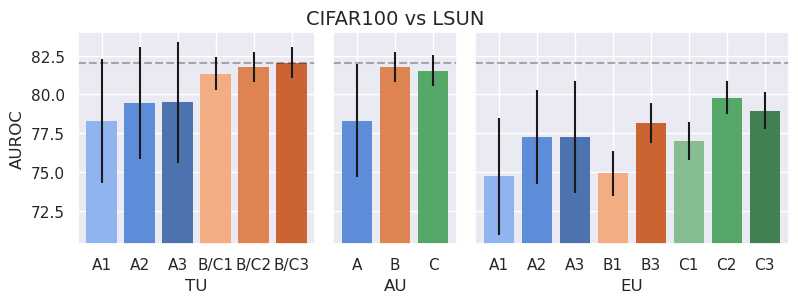

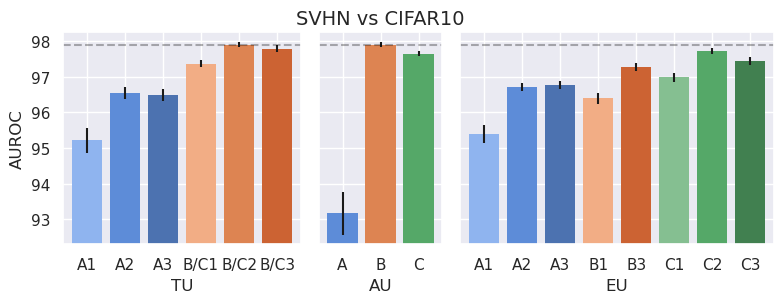

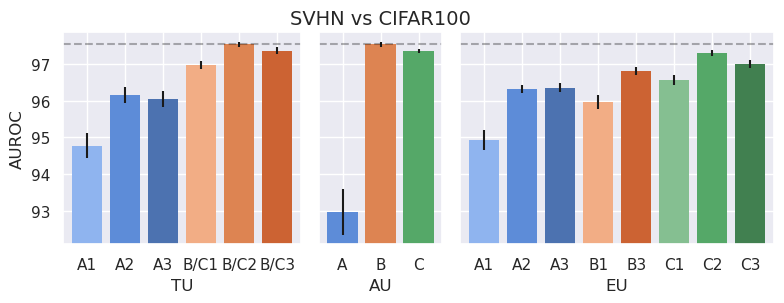

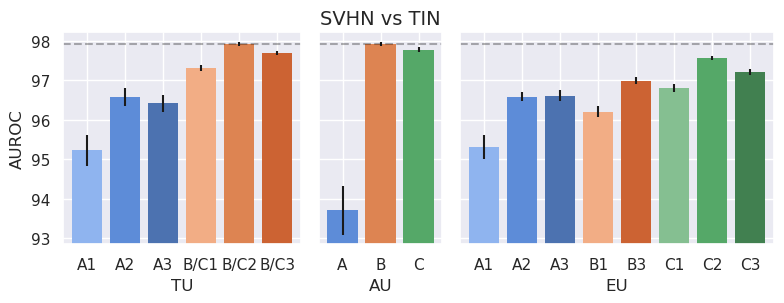

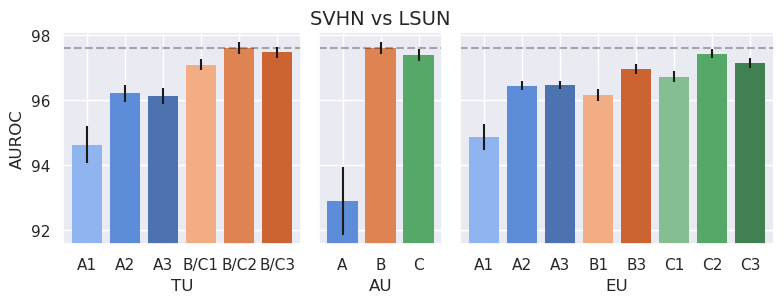

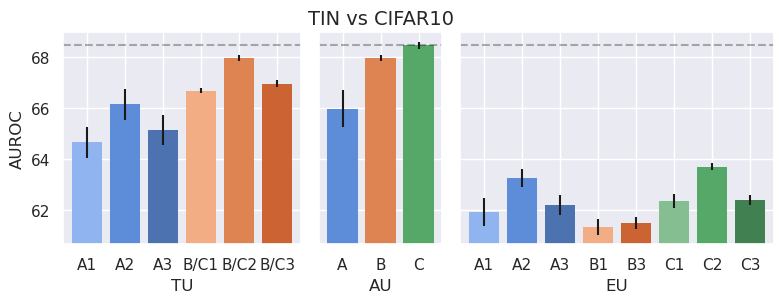

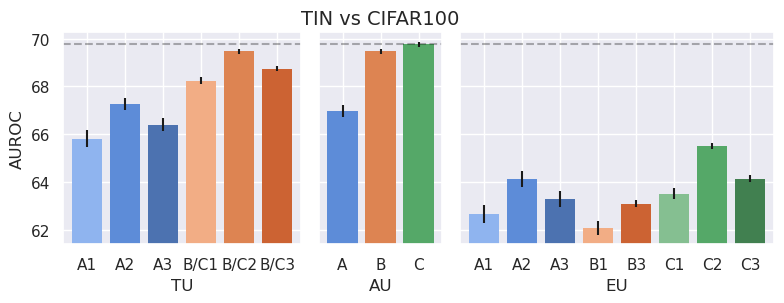

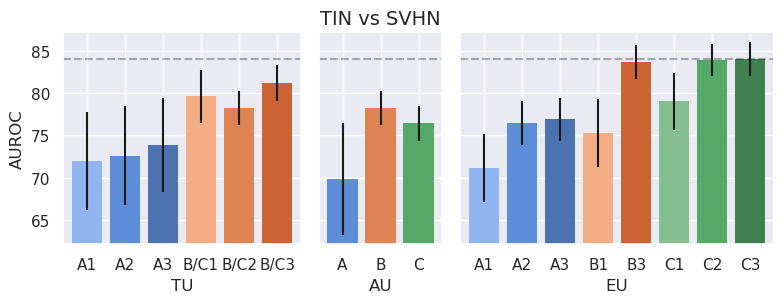

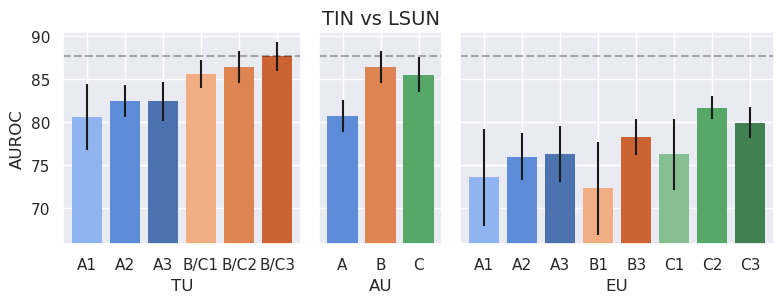

In [10]:
print(all_perfs.shape)


for i in range(len(dataset_names) - 1):
    for j in range(len(dataset_names) - 1):
        idx = i * (len(dataset_names) - 1) + j
        plot(all_perfs[i, j], f"{all_names[idx][0].upper()} vs {all_names[idx][1].upper()}")#, f"ood_det_{method}_{model}_{metric.__name__}_{all_names[idx][0]}_{all_names[idx][1]}")


# plt_data = torch.mean(all_perfs, dim=(1))

# for i in range(len(dataset_names) - 1):
#     plot(plt_data[i], f"{dataset_names[i].upper()} vs OOD", f"ood_det_{method}_{model}_{metric.__name__}_{dataset_names[i]}")